In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [2]:
# virus tracker data (broken)
# m = pd.read_csv('data/virus_tracker_mapping.txt', sep='\t',
#                 names=['country', 'countrycode', '_'], usecols=['country', 'countrycode'])
# m['country'] = m['country'].str[3:]
# m['countrycode'] = m['countrycode'].str[:2]
# m.rename(columns=str.title, inplace=True)
# m.set_index('Countrycode', inplace=True)

# df = pd.DataFrame(data['data'])
# countrycodes = set(df['countrycode'])
# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
# df.rename(columns=str.title)
# df.sort_values(['countrycode', 'date'], inplace=True)
# df.rename(columns=str.title, inplace=True)
# df.set_index(['Countrycode', 'Date'] , inplace=True)
# df = df.applymap(int)

In [3]:
df, countries = datasets.jhu()

In [4]:
colors = ['tab:orange', 'tab:red', 'tab:green']

def draw_timeline(data, country):
    fig, ax = plt.subplots(figsize=(9, 6))
    c, d, r = data.last('1D').iloc[0]
    for (label, content), color, i in zip(data.iteritems(), colors, [0, 0, 5 if (d-r)/(r+1e-10) <= 0.15 else -5]):
        ax.plot(content, label=label, color=color)
        ax.annotate(content[-1], xy=(ax.get_xticks()[-1], content[-1]),
                    xycoords=ax.transData, xytext=(30, i), textcoords='offset points',
                    va='center', ha='left', fontsize=8)
    ax.set_title(f'{country}')
    ax.get_xaxis().set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.savefig(f'./country_timeline/{country.replace(" ", "-")}.png')

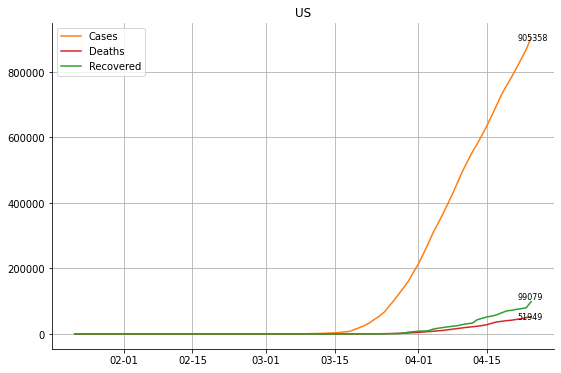

In [5]:
c = 'US'
draw_timeline(df.loc[c], c)

In [6]:
for country in countries:
    draw_timeline(df.loc[country], country)
    plt.close()

In [7]:
# generate text from markdown
# import os
# _ = 'A'
# print(f'### {_}')
# for file in [file for file in sorted(os.listdir('country_timeline')) if file.endswith('png')][1:]:
#     if file[0] > _:
#         _ = file[0]
#         print(f'### {_}')
#     print(f'![](country_timeline/{file})')

In [8]:
df.rename(index=lambda country: 'UK' if country == 'United Kingdom' else country, inplace=True)
today = df.groupby('Country').last()
today.head()

,Cases,Deaths,Recovered
Country,,,
Afghanistan,1351,43,188
Albania,678,27,394
Algeria,3127,415,1408
Andorra,731,40,344
Angola,25,2,6


In [9]:
font_dict = dict(fontsize=16)

def breakout_timeline(ax, country, category, threshold, window_size):
    df_country = df.loc[country][category]
    daily_new = (df_country - df_country.shift(1, fill_value=0))
    daily_new.index = range(daily_new.shape[0])
    for i, value in daily_new.iteritems():
        if value >= threshold:
            break
    daily_new = daily_new[i:].reset_index()[category].rolling(window_size, min_periods=1).mean()
    ax.plot(daily_new, label=country)
    ax.text(daily_new.shape[0], daily_new.iloc[-1], country, font_dict)

In [10]:
def breakout_timelines(category, threshold=10, window_size=7):
    fig, ax = plt.subplots(figsize=(18, 9))
    for country in today.sort_values(category, ascending=False).index[:7]:
        breakout_timeline(ax, country, category, threshold=threshold, window_size=window_size)

    ax.set_ylabel(f'daily new {category.lower()}', fontsize=12)
    ax.set_xlabel(f'number of days since {threshold} {category.lower()} recorded', fontsize=12)
    ax.grid()
    ax.set_xbound(lower=0)
    ax.set_ybound(lower=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Growth of {category.lower()}')
#     ax.legend()
    plt.savefig(f'global/{category.lower()}_breakout_timeline.png')
    plt.show()

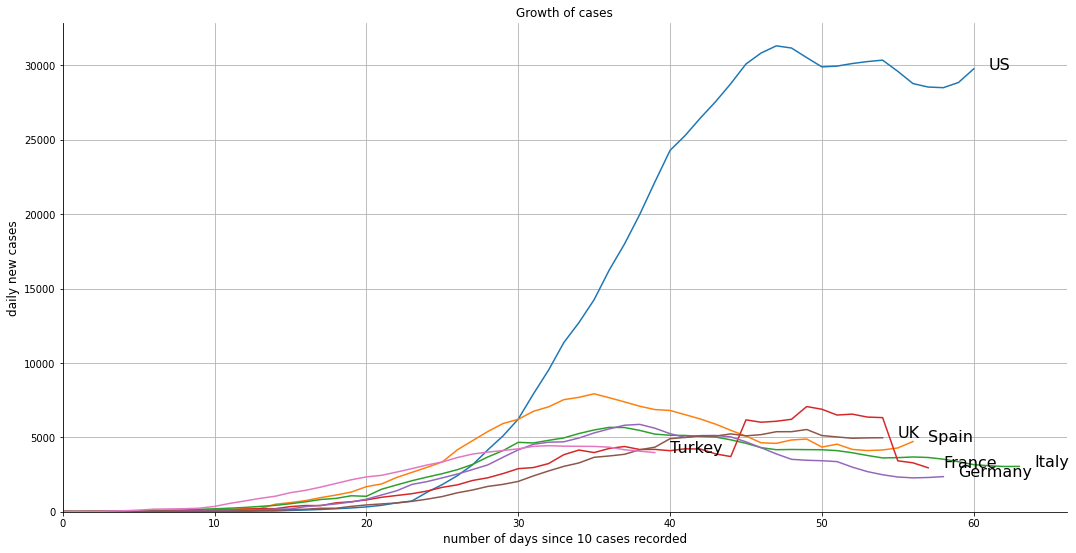

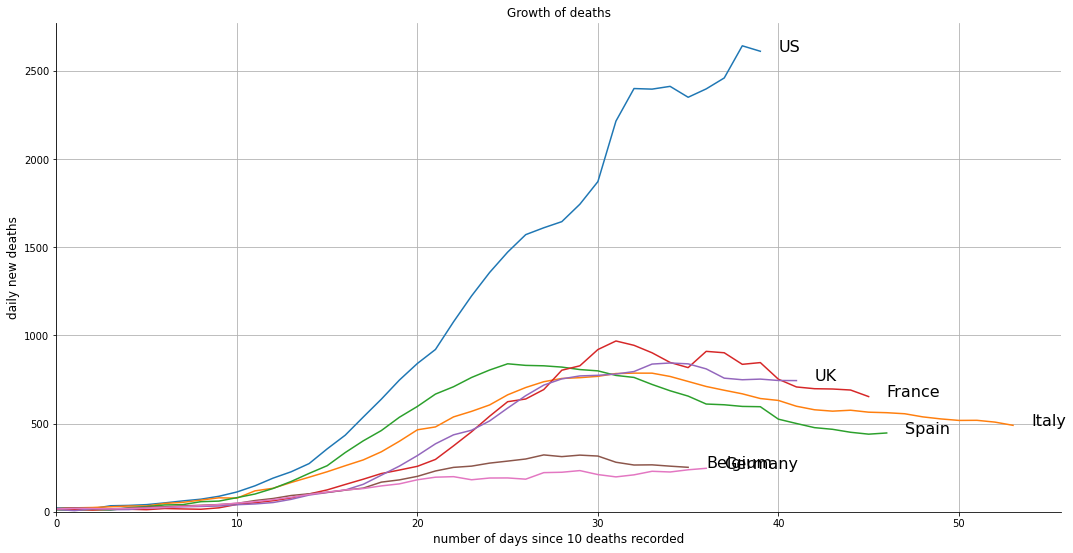

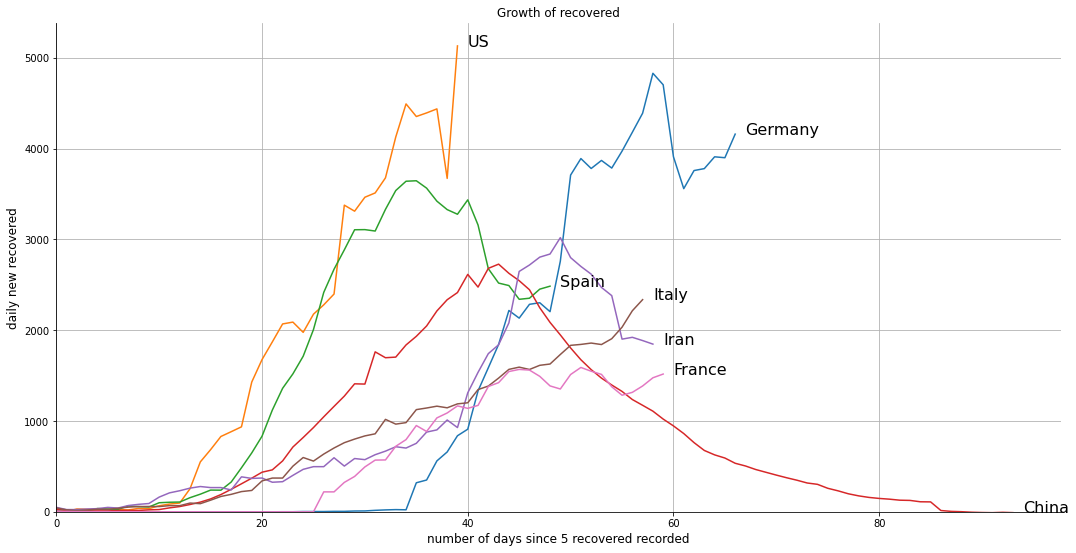

In [11]:
breakout_timelines('Cases', 10, 10)
breakout_timelines('Deaths', 10, 10)
breakout_timelines('Recovered', 5, 10)